## **Some info:**
the kaggle notebook link: https://www.kaggle.com/code/mohammedsallal/pcb-defects-classification#Testing-the-model <br>
the paper link: https://arxiv.org/pdf/1901.08204 <br>
the dataset link: https://www.kaggle.com/datasets/akhatova/pcb-defects

## **About Dataset**

#### Context
The Open Lab on Human Robot Interaction of Peking University has released the PCB defect dataset.<br>
6 types of defects are made by photoshop, a graphics editor published by Adobe Systems.<br> The defects defined in the dataset are: missing hole, mouse bite, open circuit, short, spur, and spurious copper

#### Content
This is a public synthetic PCB dataset containing 1386 images with 6 kinds of defetcs <br>
(missing hole, mouse bite, open circuit, short, spur, spurious copper)<br> 
for the use of detection, classification and registration tasks.

#### Goal
To train, evaluate, and save the Convolutional Neural Network (CNN) for classifying 6 types of PCB defects.

## **1. Setup and Imports**

#### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

#### Folders paths

In [4]:
BASE_PATH = '/kaggle/input/pcb-defects/PCB_DATASET' # This is the main folder

IMAGE_DIR = os.path.join(BASE_PATH, 'images')
ANNOTATION_DIR = os.path.join(BASE_PATH, 'Annotations')
TEMPLATE_DIR = os.path.join(BASE_PATH, 'PCB_USED')

## **2. Data Loading and Parsing**

In [7]:
# Loading the normal data images we will train on 
image_files = []

for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} total images.")

Found 693 total images.


In [8]:
# Mapping each image with its .xml Annotation

data_map = []

print("Mapping images to annotations...")
for img_path in tqdm(image_files):
    filename_without_ext = os.path.splitext(os.path.basename(img_path))[0]
    defect_type = os.path.basename(os.path.dirname(img_path))
    xml_path = os.path.join(ANNOTATION_DIR, defect_type, filename_without_ext + '.xml')
    
    if os.path.exists(xml_path):
        data_map.append((img_path, xml_path))
    else:
        print(f"Warning: Could not find annotation for {img_path}")

print(f"Successfully mapped {len(data_map)} image/annotation pairs.")

print("Example data map entry:")
print(data_map[0])

# --- The XML Specialist Function ---

def parse_xml(xml_path):
    """
    Parses an XML annotation file and extracts defect names and bounding boxes.
    
    Input:
      xml_path (str): The file path to the .xml file.
      
    Output:
      A list of dictionaries. Each dictionary contains:
      {'name': defect_name, 'bbox': [xmin, ymin, xmax, ymax]}
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    defects = []
    
    for obj in root.findall('object'):
        defect_name = obj.find('name').text
        
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        defect_info = {
            'name': defect_name,
            'bbox': [xmin, ymin, xmax, ymax]
        }
        defects.append(defect_info)
        
    return defects

Mapping images to annotations...


100%|██████████| 693/693 [00:02<00:00, 267.87it/s]

Successfully mapped 693 image/annotation pairs.
Example data map entry:
('/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite/01_mouse_bite_20.jpg', '/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite/01_mouse_bite_20.xml')


In [9]:
# --- Verification Step ---
# Let's test our parse_xml function on the first XML file in our map

if data_map:
    first_xml_path = data_map[0][1] 
    
    print(f"Testing parser on: {first_xml_path}")
    
    try:
        defects_found = parse_xml(first_xml_path)
        
        print("Successfully parsed! Defects found:")
        print(defects_found)
        
        print("\nThis XML corresponds to image:")
        print(data_map[0][0])
        
    except Exception as e:
        print(f"Error parsing XML file {first_xml_path}: {e}")
else:
    print("data_map is empty. Did the previous cell run correctly?")
    

Testing parser on: /kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite/01_mouse_bite_20.xml
Successfully parsed! Defects found:
[{'name': 'mouse_bite', 'bbox': [1339, 1366, 1382, 1410]}, {'name': 'mouse_bite', 'bbox': [995, 1312, 1040, 1351]}, {'name': 'mouse_bite', 'bbox': [792, 1296, 834, 1340]}]

This XML corresponds to image:
/kaggle/input/pcb-defects/PCB_DATASET/images/Mouse_bite/01_mouse_bite_20.jpg


Displaying a comparison (as seen in paper's Figure 3)


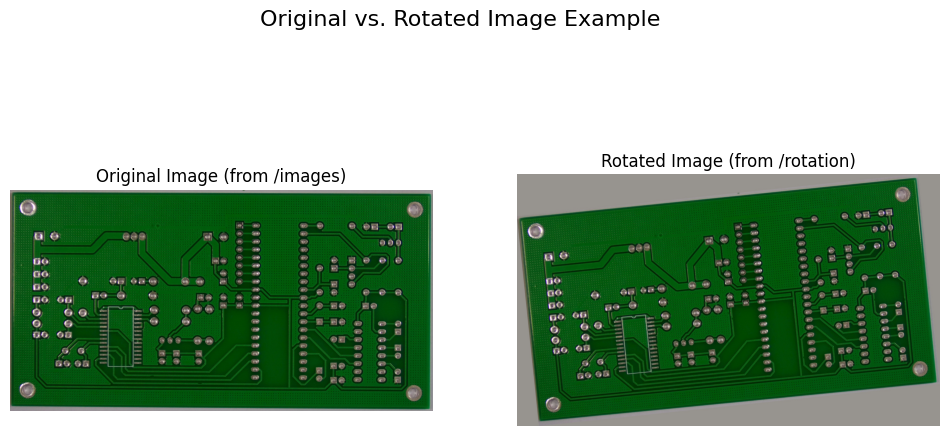

In [15]:
# --- Define the path to the rotation folder ---
# We use the BASE_PATH you provided
ROTATION_DIR = os.path.join(BASE_PATH, 'rotation')

# --- Find a 'mouse_bite' image to use as an example ---
example_img_path = ""
for img_path, xml_path in data_map:
    # We'll just find the first image that has 'mouse_bite' in its path
    if 'mouse_bite' in img_path:
        example_img_path = img_path
        break # Stop as soon as we find one

if example_img_path:
    # --- Construct the path for the rotated version ---
    # We replace the 'images' part of the path with the 'rotation' part
    rotated_example_path = '/kaggle/input/pcb-defects/PCB_DATASET/rotation/Mouse_bite_rotation/01_mouse_bite_01.jpg'
    
    # --- Load both images using OpenCV ---
    original_img = cv2.imread(example_img_path)
    rotated_img = cv2.imread(rotated_example_path)
    
    # --- Check if both images loaded successfully ---
    if original_img is not None and rotated_img is not None:
        
        print("Displaying a comparison (as seen in paper's Figure 3)")
        
        # --- Plot them side-by-side ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot 1: Original Image
        axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image (from /images)")
        axes[0].axis('off')
        
        # Plot 2: Rotated Image
        axes[1].imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Rotated Image (from /rotation)")
        axes[1].axis('off')
        
        plt.suptitle("Original vs. Rotated Image Example", fontsize=16)
        plt.show()
        
    else:
        print(f"Error: Could not load one of the images.")
        print(f"Original path: {example_img_path}")
        print(f"Rotated path: {rotated_example_path}")
else:
    print("Error: Could not find a 'mouse_bite' image to use as an example.")

## **3. Building the Dataset**

In [10]:
# Encoding the labels for the model
DEFECT_CLASSES = [
    'missing_hole', 
    'mouse_bite', 
    'open_circuit', 
    'short', 
    'spur', 
    'spurious_copper'
]

# Create a mapping from name (string) to label (integer)
# 'missing_hole' -> 0, 'mouse_bite' -> 1, etc.
class_to_label = {class_name: i for i, class_name in enumerate(DEFECT_CLASSES)}

# We'll also create the reverse map, just in case we need it later
label_to_class = {i: class_name for i, class_name in enumerate(DEFECT_CLASSES)}

print("Defect Class Mapping:")
print(class_to_label)

Defect Class Mapping:
{'missing_hole': 0, 'mouse_bite': 1, 'open_circuit': 2, 'short': 3, 'spur': 4, 'spurious_copper': 5}


In [11]:
all_defects = [] # This will hold all the 64x64 cropped image data
all_labels = []  # This will hold the matching numeric label

TARGET_SIZE = (64, 64) # the final image size 

print(f"Processing {len(data_map)} images to extract defects...")

for img_path, xml_path in tqdm(data_map):
    try:
        # 1. LOAD THE COLOR IMAGE
        image = cv2.imread(img_path)
        
        # Check if the image loaded (sometimes files can be corrupt)
        if image is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            continue
            
        # 2. PARSE THE XML
        defects = parse_xml(xml_path)
        
        # 3. LOOP THROUGH EACH DEFECT FOUND IN THE IMAGE
        for defect in defects:
            # Get the defect's name (e.g., 'short') and coordinates
            defect_name = defect['name']
            xmin, ymin, xmax, ymax = defect['bbox']
            
            # --- 4. CROP THE ORIGINAL DEFECT ---
            # NOTE: NumPy/OpenCV cropping is [y:y, x:x]
            original_crop = image[ymin:ymax, xmin:xmax]
            
            # --- 5. RESIZE THE CROP ---
            # We resize the small crop to our standard 64x64 size
            # INTER_AREA is a good algorithm for shrinking images
            resized_crop = cv2.resize(original_crop, TARGET_SIZE, interpolation=cv2.INTER_AREA)
            
            # --- 6. STORE THE DATA AND LABEL ---
            all_defects.append(resized_crop)
            all_labels.append(class_to_label[defect_name])

            # --- 7. DATA AUGMENTATION (as described in the paper) ---
            # "randomly make 5 pixel to 10 pixel offset" [cite: 266]
            # Let's create 3 augmented versions
            for _ in range(3): 
                # Get a random offset between -10 and +10 pixels
                offset_x = np.random.randint(-10, 11) 
                offset_y = np.random.randint(-10, 11)
                
                # Apply the offset to the original coordinates
                aug_xmin = xmin + offset_x
                aug_ymin = ymin + offset_y
                aug_xmax = xmax + offset_x
                aug_ymax = ymax + offset_y
                
                # Crop the new "jiggled" box
                # We add a try/except in case the jiggled box goes off-screen
                try:
                    augmented_crop = image[aug_ymin:aug_ymax, aug_xmin:aug_xmax]
                    
                    # Resize and store this new augmented sample
                    resized_aug_crop = cv2.resize(augmented_crop, TARGET_SIZE, interpolation=cv2.INTER_AREA)
                    
                    all_defects.append(resized_aug_crop)
                    all_labels.append(class_to_label[defect_name])
                except:
                    # If the jiggled box is invalid (e.g., goes off-screen), just skip it
                    pass

    except Exception as e:
        print(f"Error processing file {img_path}: {e}")

print("\n--- Processing Complete! ---")
print(f"Total defects extracted (with augmentation): {len(all_defects)}")

all_defects = np.array(all_defects)
all_labels = np.array(all_labels)

print(f"Shape of our image data: {all_defects.shape}")
print(f"Shape of our label data: {all_labels.shape}")

Processing 693 images to extract defects...


100%|██████████| 693/693 [01:26<00:00,  8.04it/s]


--- Processing Complete! ---
Total defects extracted (with augmentation): 11812
Shape of our image data: (11812, 64, 64, 3)
Shape of our label data: (11812,)


### Before Augmentation:
693 (images) $\times$ (avg. 4 defects per image) = ~2,772 original defects
### After Augmentation
(693 Images) $\times$ (~4 Defects/Image) $\times$ (4 Samples/Defect) = ~11,088 Total Samples

**Thats why i made augmentation as the paper said**


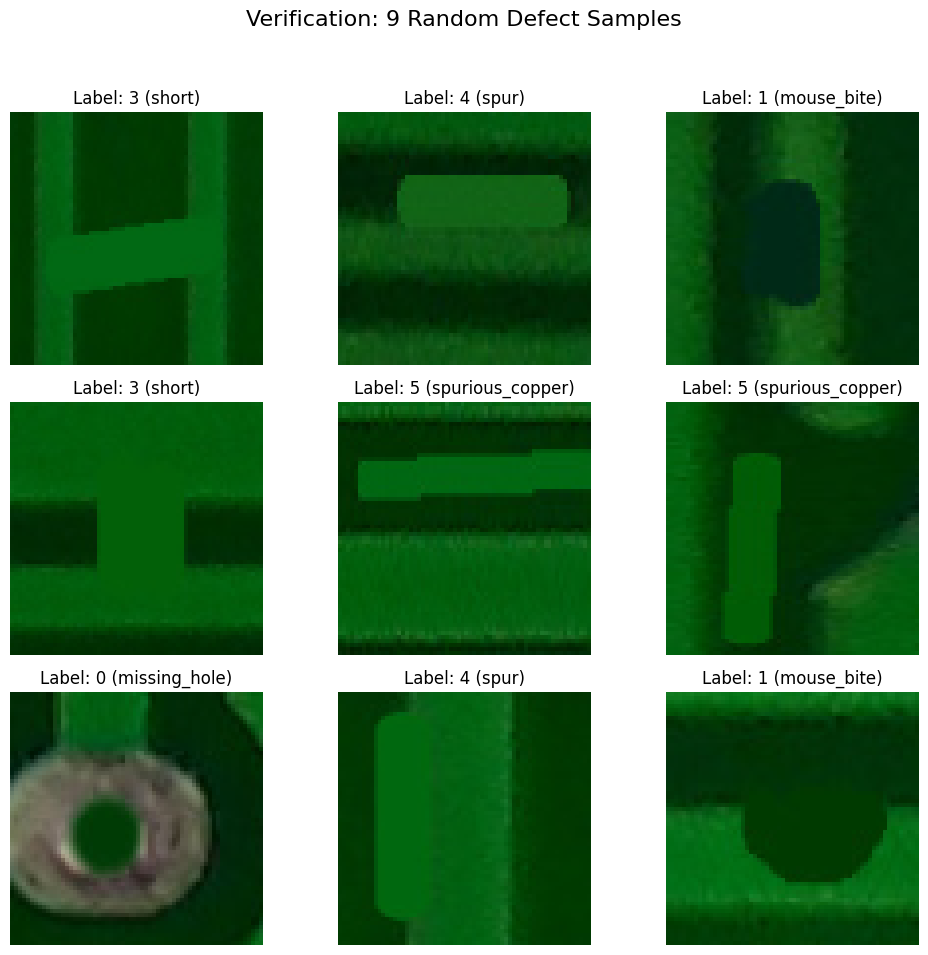

In [12]:
# --- Verification Step ---
# Let's look at 9 random samples from our new dataset

# Set up a 3x3 grid for plotting
plt.figure(figsize=(10, 10))

for i in range(9):
    # 1. Pick a random index
    idx = np.random.randint(0, len(all_defects))
    
    # 2. Get the image and its label
    image_data = all_defects[idx]
    label_number = all_labels[idx]
    
    # 3. Get the string name for that label number
    label_name = label_to_class[label_number]
    
    # 4. Create a subplot in our 3x3 grid
    plt.subplot(3, 3, i + 1)
    
    # 5. Display the image
    # We must convert BGR (from OpenCV) to RGB (for Matplotlib)
    plt.imshow(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB))
    
    # 6. Set the title
    plt.title(f"Label: {label_number} ({label_name})")
    plt.axis('off') # Hide the x/y axes

plt.suptitle("Verification: 9 Random Defect Samples", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Visualizing augmentation for one 'mouse_bite' defect...


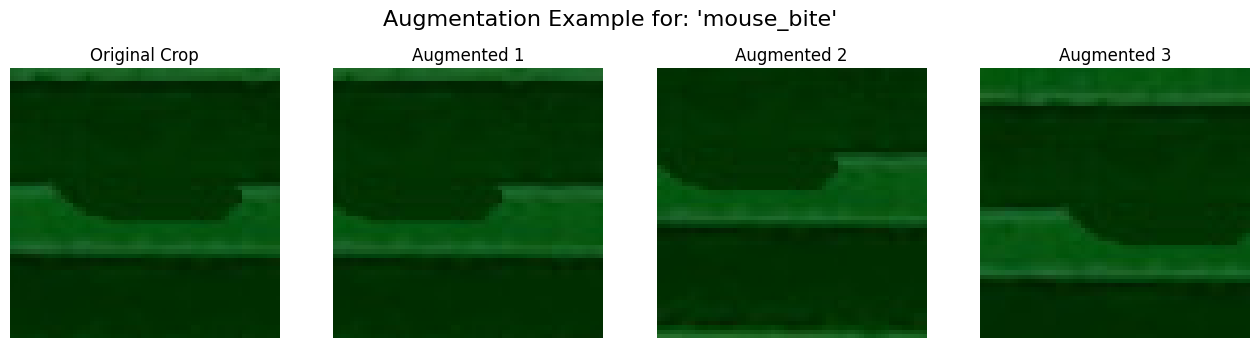

In [16]:
# --- Pick a sample image to test ---
if data_map:
    # Get the first image/xml pair
    test_img_path, test_xml_path = data_map[0]
    
    # 1. Load the color image
    image = cv2.imread(test_img_path)
    
    # 2. Parse the XML
    defects = parse_xml(test_xml_path)
    
    if image is not None and defects:
        
        # 3. Get the *first* defect from that image
        defect = defects[0]
        defect_name = defect['name']
        xmin, ymin, xmax, ymax = defect['bbox']
        
        print(f"Visualizing augmentation for one '{defect_name}' defect...")
        
        # --- Create a list to hold our images for plotting ---
        crops_to_display = []
        titles = []
        
        # --- 4. Get the ORIGINAL crop ---
        original_crop = image[ymin:ymax, xmin:xmax]
        resized_original = cv2.resize(original_crop, (64, 64), interpolation=cv2.INTER_AREA)
        crops_to_display.append(resized_original)
        titles.append("Original Crop")
        
        # --- 5. Create 3 AUGMENTED crops (same logic as Task 3) ---
        for i in range(3):
            try:
                # Get a random offset
                offset_x = np.random.randint(-10, 11) 
                offset_y = np.random.randint(-10, 11)
                
                # Apply the offset
                aug_xmin = xmin + offset_x
                aug_ymin = ymin + offset_y
                aug_xmax = xmax + offset_x
                aug_ymax = ymax + offset_y
                
                # Crop the new "jiggled" box
                augmented_crop = image[aug_ymin:aug_ymax, aug_xmin:aug_xmax]
                
                # Resize and store
                resized_aug_crop = cv2.resize(augmented_crop, (64, 64), interpolation=cv2.INTER_AREA)
                crops_to_display.append(resized_aug_crop)
                titles.append(f"Augmented {i+1}")
                
            except Exception as e:
                # If we jiggle off-screen, just print a note
                print(f"Note: Augmentation {i+1} failed (likely off-screen), skipping.")
        
        
        # --- 6. Plot all the images ---
        plt.figure(figsize=(16, 4)) # Make the figure wide
        
        for i in range(len(crops_to_display)):
            plt.subplot(1, 4, i + 1) # (1 row, 4 columns, plot number i+1)
            
            # Convert BGR to RGB for plotting
            plt.imshow(cv2.cvtColor(crops_to_display[i], cv2.COLOR_BGR2RGB))
            
            plt.title(titles[i])
            plt.axis('off')
            
        plt.suptitle(f"Augmentation Example for: '{defect_name}'", fontsize=16)
        plt.show()
        
    else:
        print("Error: Could not load image or find defects for visualization.")
else:
    print("Error: data_map is empty. Did Task 2 run?")

## **4. Create DataLoaders**

**Normalize**: We'll rescale the pixel values to be between 0 and 1.

**Split**: We'll divide our data into Training, Validation, and Test sets.

**Batch**: We'll create "data loaders" that feed the data to the model in small, efficient batches.

#### Normalization

In [17]:
all_defects_normalized = all_defects.astype('float32') / 255.0

print("Data normalized.")
print(f"Original max pixel value: {np.max(all_defects)}")
print(f"Normalized max pixel value: {np.max(all_defects_normalized)}")

Data normalized.
Original max pixel value: 255
Normalized max pixel value: 1.0


#### Splitting the Data

In [18]:
# We need to import the train_test_split function
from sklearn.model_selection import train_test_split

# --- 2. Split the data ---
# We'll use an 80% train, 10% validation, 10% test split.

# First, split into 80% train and 20% "temporary" (for val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_defects_normalized, 
    all_labels, 
    test_size=0.2,    # 20% will be for the temp set
    random_state=42,  # '42' is just a number to ensure we get the same "random" split every time
    stratify=all_labels # This is important! It ensures all 6 defect classes are fairly represented in all sets
)

# Now, split the 20% "temporary" set into half (50% of 20% = 10% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5,    # 50% of the temp set
    random_state=42,
    stratify=y_temp   # Stratify again
)

# --- Verification: Let's check our work ---
print("Data splitting complete.")
print(f"Training images shape:   {X_train.shape}")
print(f"Training labels shape:   {y_train.shape}")
print(f"Validation images shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test images shape:       {X_test.shape}")
print(f"Test labels shape:       {y_test.shape}")

Data splitting complete.
Training images shape:   (9449, 64, 64, 3)
Training labels shape:   (9449,)
Validation images shape: (1181, 64, 64, 3)
Validation labels shape: (1181,)
Test images shape:       (1182, 64, 64, 3)
Test labels shape:       (1182,)


#### Ckeck data balance

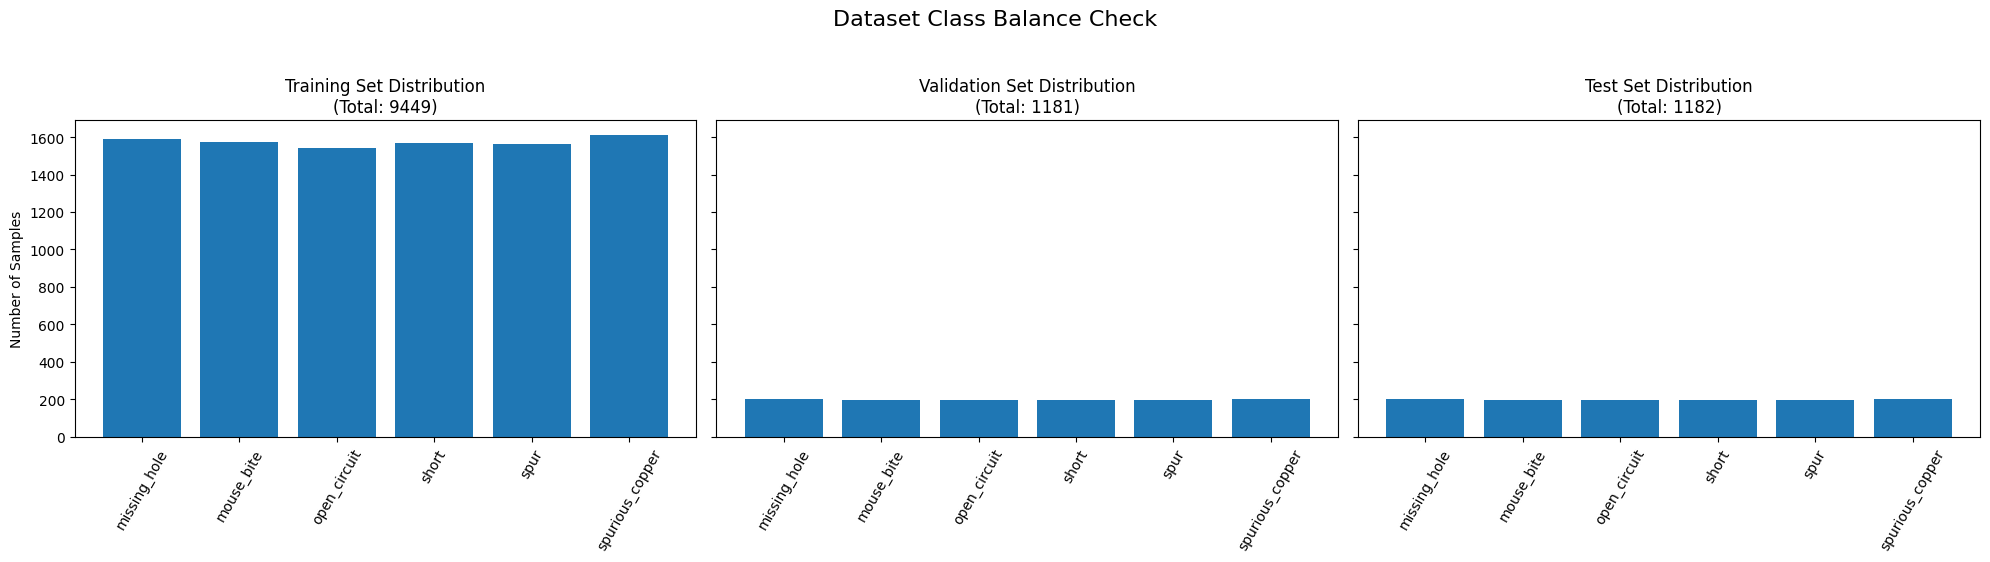

--- Training Set Counts ---
  missing_hole (Label 0): 1590 samples
  mouse_bite (Label 1): 1574 samples
  open_circuit (Label 2): 1542 samples
  short (Label 3): 1571 samples
  spur (Label 4): 1562 samples
  spurious_copper (Label 5): 1610 samples

--- Validation Set Counts ---
  missing_hole (Label 0): 199 samples
  mouse_bite (Label 1): 197 samples
  open_circuit (Label 2): 193 samples
  short (Label 3): 196 samples
  spur (Label 4): 195 samples
  spurious_copper (Label 5): 201 samples

--- Test Set Counts ---
  missing_hole (Label 0): 199 samples
  mouse_bite (Label 1): 197 samples
  open_circuit (Label 2): 193 samples
  short (Label 3): 197 samples
  spur (Label 4): 195 samples
  spurious_copper (Label 5): 201 samples


In [20]:
# --- Get the counts for each label in each set ---
# np.unique() is a handy function that returns the unique labels
# and how many times each one appears.
train_labels, train_counts = np.unique(y_train, return_counts=True)
val_labels, val_counts = np.unique(y_val, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)

# Get the class names (e.g., 'missing_hole') from our mapping
# We need to make sure they are in the correct order (0, 1, 2...)
class_names = [label_to_class[i] for i in range(len(DEFECT_CLASSES))]

# --- Plot the distributions ---
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True) # 1 row, 3 columns

# Plot 1: Training Set
axes[0].bar(class_names, train_counts)
axes[0].set_title(f'Training Set Distribution\n(Total: {np.sum(train_counts)})')
axes[0].set_ylabel('Number of Samples')
# Rotate x-axis labels to prevent overlap
axes[0].tick_params(axis='x', rotation=60)

# Plot 2: Validation Set
axes[1].bar(class_names, val_counts)
axes[1].set_title(f'Validation Set Distribution\n(Total: {np.sum(val_counts)})')
axes[1].tick_params(axis='x', rotation=60)

# Plot 3: Test Set
axes[2].bar(class_names, test_counts)
axes[2].set_title(f'Test Set Distribution\n(Total: {np.sum(test_counts)})')
axes[2].tick_params(axis='x', rotation=60)

plt.suptitle('Dataset Class Balance Check', fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout
plt.show()

# --- Print the exact numbers ---
print("--- Training Set Counts ---")
for label, count in zip(train_labels, train_counts):
    print(f"  {label_to_class[label]} (Label {label}): {count} samples")
    
print("\n--- Validation Set Counts ---")
for label, count in zip(val_labels, val_counts):
    print(f"  {label_to_class[label]} (Label {label}): {count} samples")

print("\n--- Test Set Counts ---")
for label, count in zip(test_labels, test_counts):
    print(f"  {label_to_class[label]} (Label {label}): {count} samples")

#### Batching

In [19]:
BATCH_SIZE = 8

# --- Training Dataset ---
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Validation Dataset ---
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Test Dataset ---
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Created tf.data.Dataset objects with batch size {BATCH_SIZE}.")

# --- Verification: Let's inspect one batch ---
print("\nVerifying one batch from the training dataset:")
for images, labels in train_dataset.take(1): # .take(1) grabs just one batch
    print(f"  Images batch shape: {images.shape}")
    print(f"  Labels batch shape: {labels.shape}")
    print(f"  Example labels: {labels.numpy()}")

I0000 00:00:1761394039.525107      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761394039.525818      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Created tf.data.Dataset objects with batch size 8.

Verifying one batch from the training dataset:
  Images batch shape: (8, 64, 64, 3)
  Labels batch shape: (8,)
  Example labels: [3 1 4 3 1 4 3 0]


## **5. Build the CNN Model**

In [21]:
GROWTH_RATE = 32

def dense_layer(input_tensor):
    """
    This creates one "H_l" layer from Figure 12a.
    BN-ReLU-Conv(1x1) - BN-ReLU-Conv(3x3)
    """
    # Bottleneck (1x1 Conv)
    # Paper says this produces 4 * 32 = 128 maps
    x = layers.BatchNormalization()(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(GROWTH_RATE * 4, (1, 1), strides=(1, 1), padding='same')(x)
    
    # Feature Extractor (3x3 Conv)
    # Paper says this produces 32 maps (our GROWTH_RATE)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(GROWTH_RATE, (3, 3), strides=(1, 1), padding='same')(x)
    
    return x

In [22]:
def dense_block(input_tensor, num_layers=6):
    """
    This creates one "Block" from Figure 12b.
    It stacks 'num_layers' (6 in the paper) dense_layers.
    """
    
    # This list will hold the outputs from all layers in the block
    # It starts with the block's main input
    feature_list = [input_tensor]
    
    # We loop 6 times (as specified in the paper [cite: 279])
    for i in range(num_layers):
        # Concatenate all features we've collected so far
        # This is the key "dense" step [cite: 281]
        x = layers.Concatenate(axis=-1)(feature_list) 
        
        # Pass the concatenated features to a new dense_layer
        output = dense_layer(x)
        
        # Add the output of this new layer to our list
        feature_list.append(output)
        
    # After the loop, we have all features.
    # The final output of the block is the concatenation of ALL features
    final_output = layers.Concatenate(axis=-1)(feature_list)
    
    return final_output

In [23]:
def transition_layer(input_tensor):
    """
    This is the "Transition Layer" from Table III.
    It halves the number of channels and the spatial dimensions.
    """
    # Get the number of channels (features) in the input
    num_channels = input_tensor.shape[-1]
    
    # BN-ReLU-Conv(1x1)
    # This halves the number of channels
    x = layers.BatchNormalization()(input_tensor)
    x = layers.ReLU()(x)
    x = layers.Conv2D(num_channels // 2, (1, 1), strides=(1, 1), padding='same')(x)
    
    # 2x2 Average Pooling
    # This halves the height and width
    x = layers.AveragePooling2D((2, 2), strides=2)(x)
    
    return x

In [24]:
def create_model(input_shape=(64, 64, 3), num_classes=6):
    """
    Assembles the full network from Figure 12.
    """
    
    # 1. Define the input
    inputs = keras.Input(shape=input_shape)
    
    # 2. Initial Convolution + Pooling (from Table III )
    # 7x7 Conv, stride 2 (64x64 -> 32x32)
    # We use 64 filters (2 * GROWTH_RATE), a common choice
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    # 3x3 Max Pool, stride 2 (32x32 -> 16x16)
    x = layers.MaxPool2D((3, 3), strides=2, padding='same')(x)
    
    # 3. Block 1 (from Figure 12b [cite: 304])
    # 6-layer dense block
    x = dense_block(x, num_layers=6)
    
    # 4. Transition Layer 1 (from Figure 12b [cite: 304, 314])
    x = transition_layer(x)
    # Size is now 8x8
    
    # 5. Block 2 (from Figure 12b [cite: 304])
    # Another 6-layer dense block
    x = dense_block(x, num_layers=6)
    
    # 6. Classification Layer (from Table III [cite: 314, 315])
    # "Adaptive Avg Pool" = GlobalAveragePooling2D
    # This flattens the 8x8xN feature map into a 1xN vector
    x = layers.GlobalAveragePooling2D()(x)
    
    # Final 6-way fully-connected layer
    # We use 'softmax' for multi-class classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # 7. Create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

# --- Let's build it! ---
model = create_model()

# --- Verification: Print the model summary ---
# This is the best way to see our new architecture.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      8,320 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     36,896 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        384 │ concatenate_1[0]… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     12,416 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     36,896 │ re_lu_3[0][0]   

 Total params: 774,534 (2.95 MB)

 Trainable params: 766,726 (2.92 MB)

 Non-trainable params: 7,808 (30.50 KB)

## **6. Set Up Training**

In [25]:
initial_learning_rate = 0.01

decay_steps = 7 * (len(X_train) // BATCH_SIZE) # 7 * (number of batches per epoch)
decay_rate = 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True 
)

optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule,  
    momentum=0.9
)

print(f"Created SGD optimizer with 0.9 momentum and a learning rate schedule.")

Created SGD optimizer with 0.9 momentum and a learning rate schedule.


In [26]:
model.compile(
    optimizer=optimizer,  
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy'] 
)

print("Model successfully compiled!")

Model successfully compiled!


## **7. Train the Model**

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

best_model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Filename to save
    save_best_only=True,       # Only save if it's the "best"
    monitor='val_accuracy',    # What to monitor
    mode='max'                 # "Best" means the maximum accuracy
)

In [28]:
EPOCHS = 50 

print("--- Starting Model Training ---")

history = model.fit(
    train_dataset,                
    epochs=EPOCHS,                
    validation_data=val_dataset,  
    callbacks=[best_model_checkpoint] #
)

print("--- Training Complete ---")

--- Starting Model Training ---
Epoch 1/50


I0000 00:00:1761395283.873724     159 service.cc:148] XLA service 0x788f2c002030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761395283.876638     159 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761395283.876664     159 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761395285.048353     159 cuda_dnn.cc:529] Loaded cuDNN version 90300


  10/1182 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.3180 - loss: 1.6201 

I0000 00:00:1761395296.275523     159 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1182/1182 ━━━━━━━━━━━━━━━━━━━━ 47s 19ms/step - accuracy: 0.6008 - loss: 1.0607 - val_accuracy: 0.9204 - val_loss: 0.2076
Epoch 2/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9021 - loss: 0.3168 - val_accuracy: 0.9517 - val_loss: 0.1665
Epoch 3/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9344 - loss: 0.2206 - val_accuracy: 0.9873 - val_loss: 0.0474
Epoch 4/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9715 - loss: 0.0898 - val_accuracy: 0.9721 - val_loss: 0.0945
Epoch 5/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9668 - loss: 0.1096 - val_accuracy: 0.9856 - val_loss: 0.0530
Epoch 6/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9860 - loss: 0.0432 - val_accuracy: 0.9890 - val_loss: 0.0293
Epoch 7/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9835 - loss: 0.0416 - val_accuracy: 0.7621 - val_loss: 1.6743
Epoch 8/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9866 - loss: 0.0396 - val_accur

## **8. Evaluate the Model**

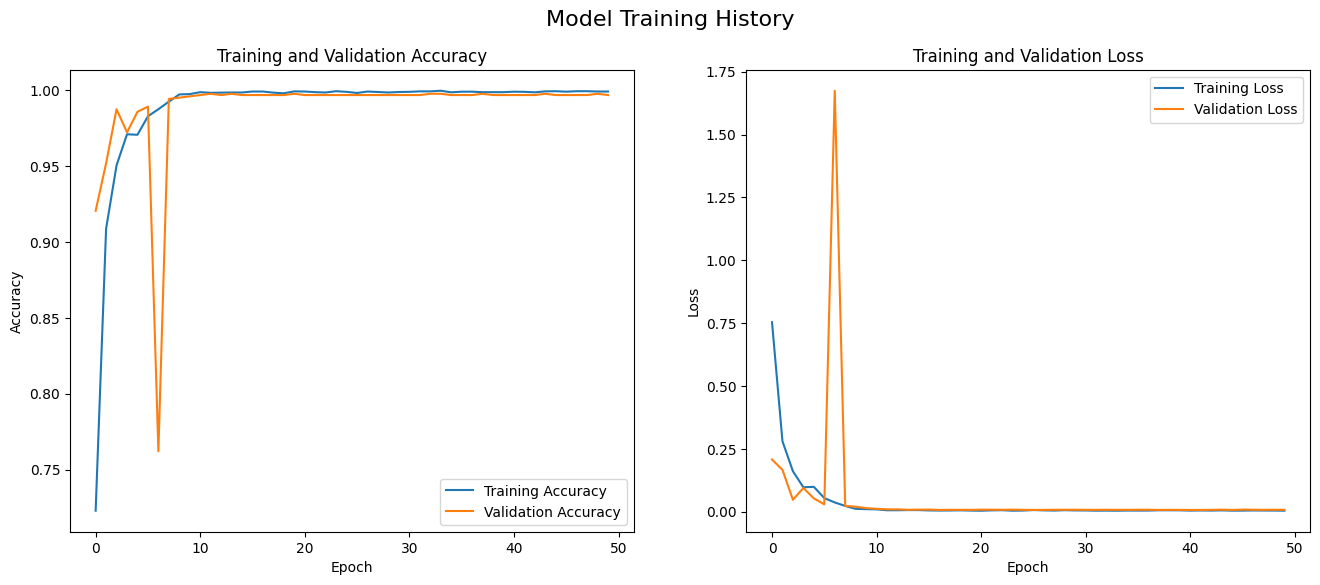

In [29]:
# --- 1. Get the data from the history object ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

# --- 2. Create the plots ---
plt.figure(figsize=(16, 6))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.suptitle('Model Training History', fontsize=16)
plt.show()

In [30]:
# --- 1. Load the best saved model ---
print("Loading the best model from 'best_model.h5'...")
# We re-create the model just to be safe, then load the weights
model = create_model() 
model.load_weights('best_model.h5')

# We must re-compile it after loading
model.compile(
    optimizer='sgd', # Optimizer type doesn't matter for evaluation, but it needs one
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Best model loaded and compiled.")

# --- 2. Evaluate on the Test Set ---
print("\n--- Evaluating on the Final Exam (Test Set) ---")
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"\nTest Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Loading the best model from 'best_model.h5'...
Best model loaded and compiled.

--- Evaluating on the Final Exam (Test Set) ---
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9961 - loss: 0.0099

Test Loss:     0.0077
Test Accuracy: 99.75%


In [33]:
# --- Find the best epoch ---

# Get the list of validation accuracies from our history
val_acc_list = history.history['val_accuracy']

# Find the index (epoch) that has the maximum accuracy
# np.argmax() is a function that returns the index of the largest value in a list
best_epoch_index = np.argmax(val_acc_list)

# Get the accuracy value itself
best_val_accuracy = val_acc_list[best_epoch_index]

# Add 1 because epochs are 0-indexed
# (Epoch 1 is at index 0, Epoch 50 is at index 49)
print(f"The best model was saved at Epoch: {best_epoch_index + 1}")
print(f"It achieved a validation accuracy of: {best_val_accuracy * 100:.2f}%")

The best model was saved at Epoch: 12
It achieved a validation accuracy of: 99.75%


Generating predictions for the test set...
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Classification Report (like Paper's Table V) ---
                 precision    recall  f1-score   support

   missing_hole       1.00      1.00      1.00       199
     mouse_bite       1.00      0.99      1.00       197
   open_circuit       0.99      1.00      1.00       193
          short       1.00      1.00      1.00       197
           spur       0.99      1.00      0.99       195
spurious_copper       1.00      0.99      0.99       201

       accuracy                           1.00      1182
      macro avg       1.00      1.00      1.00      1182
   weighted avg       1.00      1.00      1.00      1182


--- Plotting Confusion Matrix ---


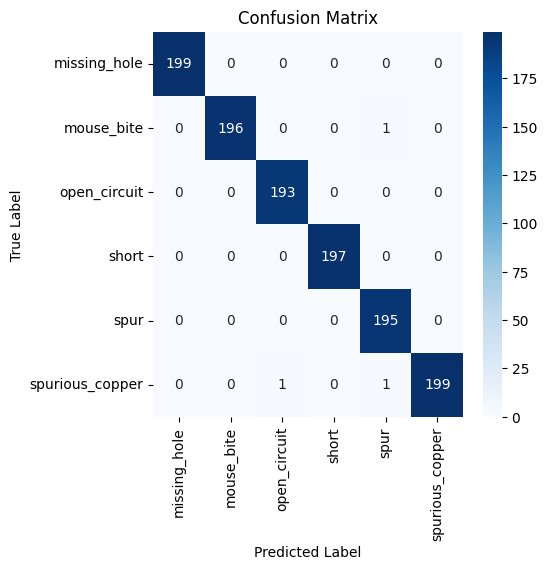

In [32]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. Get predictions for the *entire* test set ---
print("Generating predictions for the test set...")
# .predict() gives us the raw probabilities (e.g., [0.1, 0.0, 0.9, ...])
y_pred_probabilities = model.predict(test_dataset) 
# np.argmax() finds the *index* (the class) with the highest probability
y_pred = np.argmax(y_pred_probabilities, axis=1) 

# --- 2. Get the true labels ---
# We already have these in 'y_test' from Task 4
y_true = y_test

# --- 3. Print the Classification Report ---
# This gives us the Pc (precision) and APc (macro avg precision) from the paper
print("\n--- Classification Report (like Paper's Table V) ---")
print(classification_report(y_true, y_pred, target_names=DEFECT_CLASSES))

# --- 4. Plot the Confusion Matrix ---
print("\n--- Plotting Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=DEFECT_CLASSES, 
            yticklabels=DEFECT_CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Testing the model**

Loading trained model...
Model loaded.
Loaded Template: /kaggle/input/pcb-defects/PCB_DATASET/PCB_USED/01.JPG
Loaded Test Image: /kaggle/input/pcb-defects/PCB_DATASET/rotation/Mouse_bite_rotation/01_mouse_bite_01.jpg


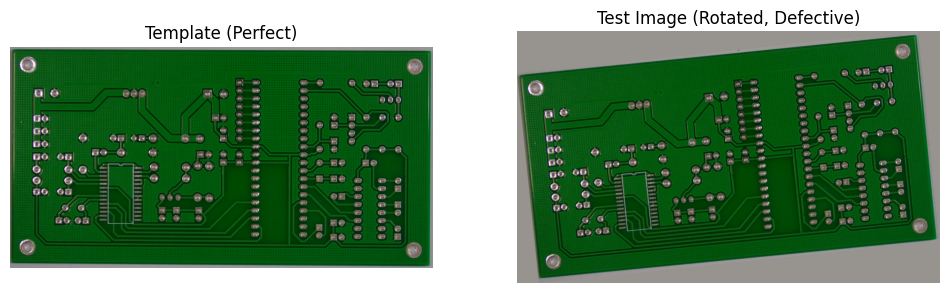

In [37]:
# --- 1. Load our trained model ---
print("Loading trained model...")
model = create_model()
model.load_weights('best_model.h5')
print("Model loaded.")

# --- 2. Load Template and Test Image ---
# We'll use template 01.JPG
template_path = os.path.join(TEMPLATE_DIR, '01.JPG')

# And we'll use a rotated, defective version of 01.JPG
# Let's find one, e.g., a "mouse_bite" one
test_image_name = '01_mouse_bite_01.jpg'
test_image_path = os.path.join(ROTATION_DIR, 'Mouse_bite_rotation', test_image_name)

# Load the color images
template_color = cv2.imread(template_path)
test_color = cv2.imread(test_image_path)

# Load the grayscale images (for Phase 1)
template_gray = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY)
test_gray = cv2.cvtColor(test_color, cv2.COLOR_BGR2GRAY)

print(f"Loaded Template: {template_path}")
print(f"Loaded Test Image: {test_image_path}")

# --- 3. Plot them ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Template (Perfect)")
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(test_color, cv2.COLOR_BGR2RGB))
axes[1].set_title("Test Image (Rotated, Defective)")
axes[1].axis('off')
plt.show()

#### Registration

Finding keypoints...
Matching keypoints...
Finding transformation...
Warping (aligning) test image...


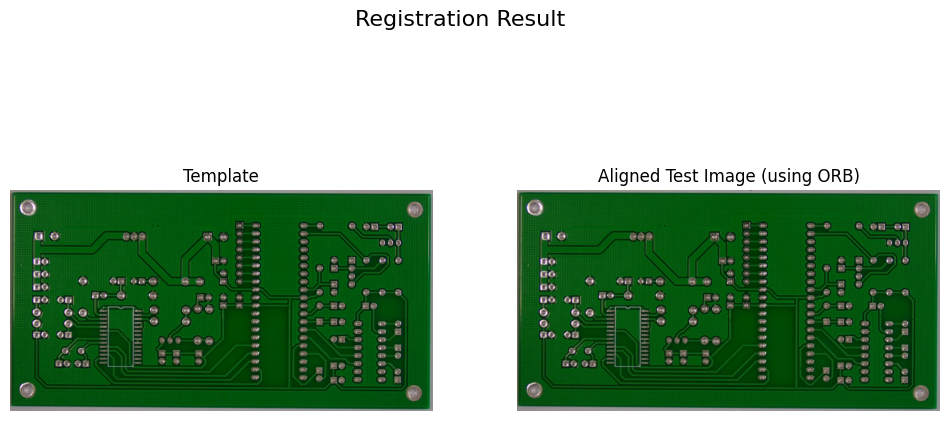

In [45]:
# --- 1. Create ORB detector ---
# We'll ask it to find up to 1000 keypoints
try:
    orb = cv2.ORB_create(nfeatures=1000)
except Exception as e:
    print(f"Error creating ORB: {e}")
    print("This is strange, ORB should be in the main cv2 package.")
    raise

# --- 2. Find Keypoints and Descriptors ---
print("Finding keypoints...")
kp1, des1 = orb.detectAndCompute(template_gray, None)
kp2, des2 = orb.detectAndCompute(test_gray, None)

# --- 3. Match Keypoints ---
print("Matching keypoints...")
# ORB uses binary descriptors, so we use NORM_HAMMING
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort them in the order of their distance (best matches first)
matches = sorted(matches, key=lambda x: x.distance)

# --- 4. Get Transformation (Homography) ---
print("Finding transformation...")
# We still need at least 10 good matches
if len(matches) > 10:
    # Get the (x,y) coordinates of the good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # M is the 3x3 transformation matrix
    # We find the matrix to transform the test image (dst) to the template (src)
    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    
    # --- 5. "Warp" the Test Image ---
    print("Warping (aligning) test image...")
    # Get the size (height, width) of the template
    h, w = template_gray.shape
    # Apply the transformation M to the test image
    aligned_color = cv2.warpPerspective(test_color, M, (w, h))
    aligned_gray = cv2.cvtColor(aligned_color, cv2.COLOR_BGR2GRAY)    
    # --- 6. Visualize Alignment ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Template")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(aligned_color, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Aligned Test Image (using ORB)")
    axes[1].axis('off')
    plt.suptitle("Registration Result", fontsize=16)
    plt.show()

else:
    print("Not enough matches found - cannot align.")
    raise Exception("Alignment Failed")

#### Binarization

Binarizing images...
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Performing XOR...


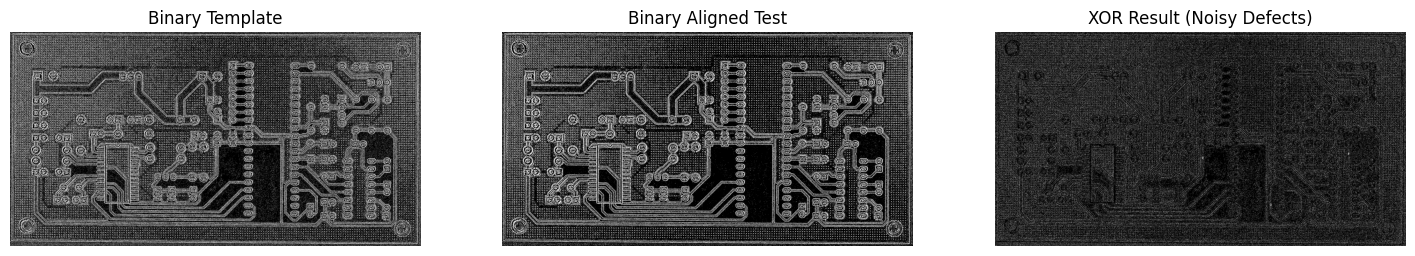

In [46]:
# --- 1. Binarization (Adaptive Threshold) ---
# Paper uses adaptive threshold [cite: 192]
print("Binarizing images...")
thresh_template = cv2.adaptiveThreshold(template_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY_INV, 11, 2)
thresh_aligned = cv2.adaptiveThreshold(aligned_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY_INV, 11, 2)

# --- 2. XOR Operation ---
print("Performing XOR...")
xor_result = cv2.bitwise_xor(thresh_template, thresh_aligned)

# --- 3. Visualize ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(thresh_template, cmap='gray')
axes[0].set_title("Binary Template")
axes[0].axis('off')

axes[1].imshow(thresh_aligned, cmap='gray')
axes[1].set_title("Binary Aligned Test")
axes[1].axis('off')

axes[2].imshow(xor_result, cmap='gray')
axes[2].set_title("XOR Result (Noisy Defects)")
axes[2].axis('off')
plt.show()

#### Morpholigical

Cleaning XOR image with Filtering and Morphology...


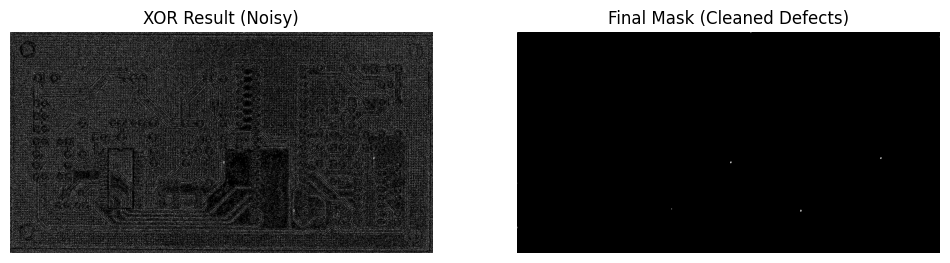

In [47]:
# --- Following Table VI from the paper ---
print("Cleaning XOR image with Filtering and Morphology...")

# 1. Median Filtering
step1 = cv2.medianBlur(xor_result, 5)

# 2. Closing
kernel_15 = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
step2 = cv2.morphologyEx(step1, cv2.MORPH_CLOSE, kernel_15)

# 3. Opening
kernel_3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
step3 = cv2.morphologyEx(step2, cv2.MORPH_OPEN, kernel_3)

# 4. Median Filtering
step4 = cv2.medianBlur(step3, 5)

# 5. Closing
kernel_29_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (29, 29))
step5 = cv2.morphologyEx(step4, cv2.MORPH_CLOSE, kernel_29_ellipse)

# 6. Opening
kernel_3_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
step6 = cv2.morphologyEx(step5, cv2.MORPH_OPEN, kernel_3_rect)
# We skip step 7 (1x1 opening) as it has no effect.

final_mask = step6

# --- Visualize the cleaning ---
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(xor_result, cmap='gray')
axes[0].set_title("XOR Result (Noisy)")
axes[0].axis('off')

axes[1].imshow(final_mask, cmap='gray')
axes[1].set_title("Final Mask (Cleaned Defects)")
axes[1].axis('off')
plt.show()

#### Cropping

In [48]:
# --- Find Contours (the defect blobs) ---
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Found {len(contours)} potential defect(s).")

# We'll store our final defect crops here
defect_crops = []
defect_bboxes = [] # Bounding boxes

for c in contours:
    # Get the bounding box (x, y, width, height)
    x, y, w, h = cv2.boundingRect(c)
    
    # --- Filter out tiny noise ---
    # If the defect is too small (e.g., < 20 pixels), ignore it
    if w < 5 or h < 5:
        continue
    
    # --- Get the crop from the ALIGNED *COLOR* image ---
    defect_crop = aligned_color[y:y+h, x:x+w]
    
    defect_crops.append(defect_crop)
    defect_bboxes.append((x, y, w, h))
    
print(f"Kept {len(defect_crops)} defect(s) after filtering.")

Found 9 potential defect(s).
Kept 3 defect(s) after filtering.


#### Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


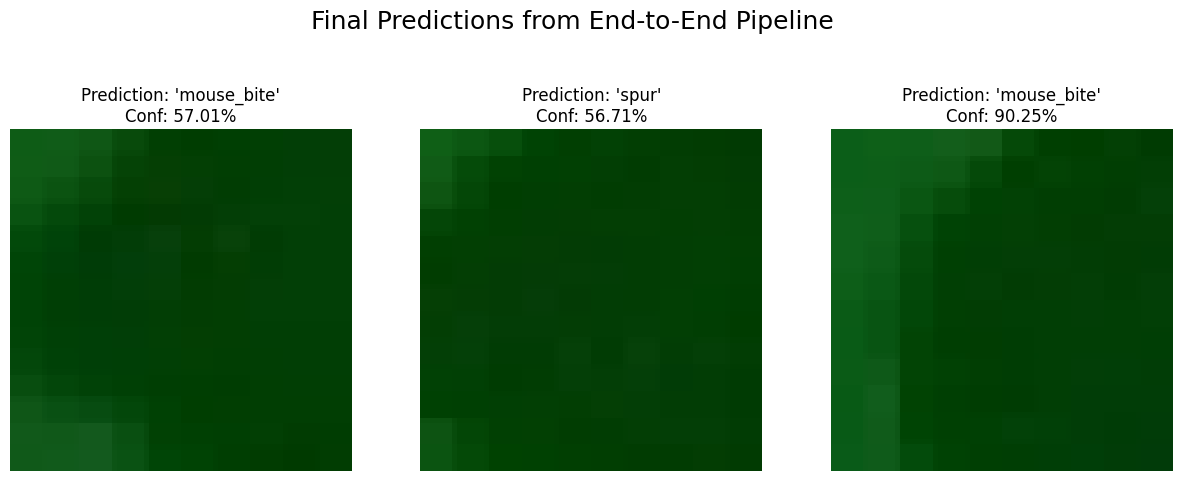

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Final Result on Aligned Image:


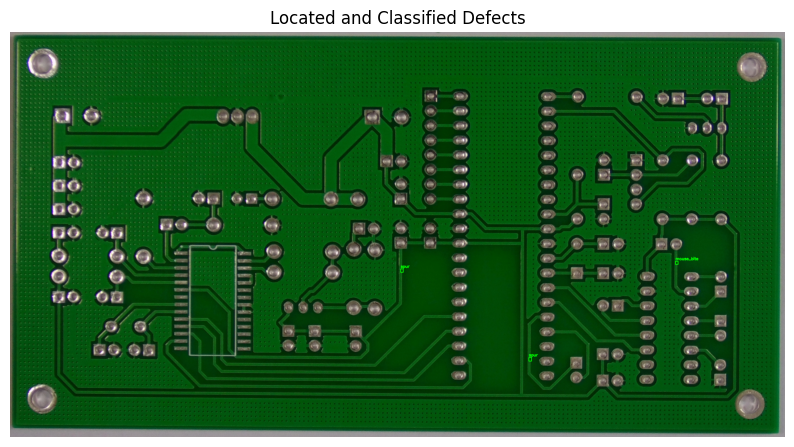

In [49]:
# --- Classify each found defect ---

if not defect_crops:
    print("No defects found to classify.")
else:
    # Create a plot for our results
    num_defects = len(defect_crops)
    plt.figure(figsize=(num_defects * 5, 6))
    
    for i, crop in enumerate(defect_crops):
        # 1. Resize to (64, 64)
        resized_crop = cv2.resize(crop, (64, 64), interpolation=cv2.INTER_AREA)
        
        # 2. Normalize (0-1 range)
        normalized_crop = resized_crop.astype('float32') / 255.0
        
        # 3. Add a "batch" dimension
        # Model expects (batch_size, 64, 64, 3), not (64, 64, 3)
        input_tensor = np.expand_dims(normalized_crop, axis=0)
        
        # 4. PREDICT!
        predictions = model.predict(input_tensor)
        
        # Get the winning class index
        pred_index = np.argmax(predictions[0])
        pred_confidence = np.max(predictions[0])
        
        # Get the class name
        pred_class_name = label_to_class[pred_index]
        
        # 5. Display the result
        plt.subplot(1, num_defects, i + 1)
        plt.imshow(cv2.cvtColor(resized_crop, cv2.COLOR_BGR2RGB))
        title = f"Prediction: '{pred_class_name}'\nConf: {pred_confidence*100:.2f}%"
        plt.title(title)
        plt.axis('off')
        
    plt.suptitle("Final Predictions from End-to-End Pipeline", fontsize=18)
    plt.show()

    # --- Draw boxes on the aligned image ---
    output_image = aligned_color.copy()
    for i, (x, y, w, h) in enumerate(defect_bboxes):
        pred_class_name = label_to_class[np.argmax(model.predict(np.expand_dims(cv2.resize(defect_crops[i],(64,64))/255.0, axis=0))[0])]
        # Draw a green rectangle
        cv2.rectangle(output_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # Put the text label
        cv2.putText(output_image, pred_class_name, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    print("\nFinal Result on Aligned Image:")
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Located and Classified Defects")
    plt.axis('off')
    plt.show()